# Analyze Region 11 - Central Europe

This notebook analyzes the largest glaciers in Region 11 - Central Europe

In [1]:
import os
import os.path as op
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio as rio
from rasterio.plot import plotting_extent
from earthpy import clip as cl
import earthpy.plot as ep

# set working dir
HOME = op.join(op.expanduser("~"))
os.chdir(os.path.join(HOME, "git/wgms-glacier-project"))

# Set up path to load scripts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import scripts.wgms_scripts as ws

# Set Up Region Info

In [2]:
# Set region number, region name, and region index
# Once these are set, this notebook should run automatically for the specified region
region_number = "11"
region_name = "Central Europe"

# The variable primeclass needs to be updated with the primary class of the ice complexes for the region
# This may need to be a list in some instances
# 2: icefield, 3: ice cap, 4: outlet glacier, 5: valley glacier, 6: mountain glacier
primeclass = 5 # GLIMS doesn't say, but Michael suggests valley

# Note for the region index, region_index_1 should be one less than the region number and 
# region_index_2 should be equal to the region number. For example, for region 1, index_1 should be set to 0 and 
# index_2 should be set to 1, etc.
region_index_1 = 10
region_index_2 = 11

# This variable sets a value to determine whether the differences between the GLIMS and RGI glacier have been checked.
# When first starting a new notebook set handled to 0
# Once the differences have been checked and handled, set to 1 to pass the check 
# in the Compare Glaciers from GLIMS and RGI section towards the middele of this notebook.
handled = 1

# Show Region

In [3]:
# Open natural earth basemap TIF file
ne_fp = 'data/natural-earth/NE1_HR_LC_SR_W/NE1_HR_LC_SR_W.tif' # 10 m res
with rio.open(ne_fp) as ne_src:
    # Convert / read the data into a numpy array:
    ne_raster = ne_src.read()
    ne_src_extent = plotting_extent(ne_src)
    bounds = ne_src.bounds
    ne_raster_meta = ne_src.meta

In [4]:
# Open glacier regions
glacier_regions_fp = "data/gtn-g-glacier-regions/cleaned/GTN-G_glacier_regions_201707_cleaned.shp"
glacier_regions = gpd.read_file(glacier_regions_fp)

# Extract Region outline
region_outline = glacier_regions[region_index_1:region_index_2]

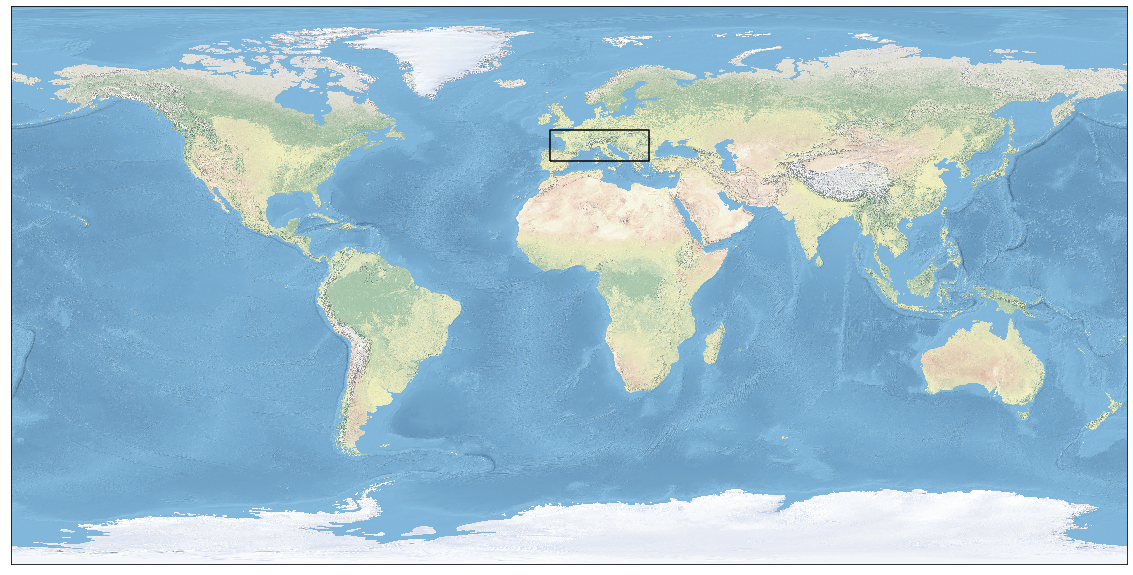

In [5]:
# Plot region outline over the natural earth
# Plot natural earth basemap
fig, ax = plt.subplots(figsize=(20, 20))

# Plot natural earth
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot region outline
region_outline.boundary.plot(ax=ax, color="black")

plt.show()

In [6]:
region_outline.bounds

,minx,miny,maxx,maxy
10,-6.0,40.0,26.0,50.0


# Glaciers

## Open GLIMS 3 Largest Glaciers Data

In [7]:
# Open GLIMS three largest glacier outlines for this region.
glims_glaciers_fn = "data/glims/processed/largest/glims_region_" + region_number + "_largest.shp"
glims_glaciers_df = gpd.read_file(glims_glaciers_fn)

In [8]:
# Check if GLIMS glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
glims_df_len = len(glims_glaciers_df)
for x in range(glims_df_len):
    if glims_glaciers_df['glac_name'][x] == None:
        print("GLIMS glacier " + str(x) + " equals none")
        glims_glaciers_df.loc[x, 'glac_name'] = 'NONE'

In [9]:
glims_glaciers_df

,region_no,glac_id,area,db_area,width,length,primeclass,min_elev,mean_elev,max_elev,src_date,glac_name,geometry
0,11,G008032E46504N,78.3819,78.3518,0.0,23576.0,0.0,1649.0,3060.0,4126.0,2009-09-15T00:00:00,GROSSER ALETSCH GLETSCHER,"POLYGON Z ((8.018387000000001 46.562885 0, 8.0..."
1,11,G007800E45965N,40.2356,40.2306,0.0,13431.0,0.0,2173.0,3335.0,4576.0,2009-09-15T00:00:00,GORNERGLETSCHER,"POLYGON Z ((7.877975 45.973549 0, 7.878131 45...."
2,11,G008144E46504N,29.4806,29.4750,0.0,15380.0,0.0,1706.0,3110.0,4084.0,2009-09-15T00:00:00,FIESCHERGLETSCHER VS,"POLYGON Z ((8.078189 46.554764 0, 8.0782120000..."
3,11,G008187E46569N,22.5094,22.5060,0.0,12621.0,0.0,1930.0,2692.0,3967.0,2009-09-15T00:00:00,UNTERAARGLETSCHER,"POLYGON Z ((8.139977999999999 46.610912 0, 8.1..."
4,11,G007964E46423N,17.4731,17.4801,0.0,9157.0,0.0,2169.0,2928.0,3811.0,2009-09-15T00:00:00,OBERALETSCH GLETSCHER,"POLYGON Z ((7.973822 46.468593 0, 7.973682 46...."
5,11,G007964E46423N,17.4731,17.4801,0.0,9157.0,0.0,2169.0,2928.0,3811.0,2009-09-15T00:00:00,OBERALETSCH GLETSCHER,"POLYGON Z ((8.004360999999999 46.44558 0, 8.00..."


## Open RGI 3 Largest Glaciers Data

In [10]:
# Open RGI three largest glacier outlines for this region.
rgi_glaciers_fn = "data/rgi/processed/largest/rgi_region_" + region_number + "_largest.shp"
rgi_glaciers_df = gpd.read_file(rgi_glaciers_fn)

In [11]:
# Check if RGI glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
rgi_df_len = len(rgi_glaciers_df)
for x in range(rgi_df_len):
    if rgi_glaciers_df['Name'][x] == None:
        print("RGI glacier " + str(x) + " equals none")
        rgi_glaciers_df.loc[x, 'Name'] = 'NONE'

RGI glacier 0 equals none
RGI glacier 1 equals none
RGI glacier 2 equals none
RGI glacier 4 equals none


In [12]:
rgi_glaciers_df

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,RGI60-11.01450,G008019E46503N,20030799,20030999,8.01919,46.5028,11,1,82.206,1607,...,149,23746,0,0,0,0,9,9,NONE,"POLYGON ((8.026477001000046 46.56196906400004,..."
1,RGI60-11.02822,G007803E45950N,20030799,20030999,7.80309,45.9502,11,1,56.464,2207,...,325,13618,0,0,0,0,9,9,NONE,"POLYGON ((7.871033715000067 45.94809386300005,..."
2,RGI60-11.01478,G008121E46517N,20030799,20030999,8.12141,46.5169,11,1,31.334,1713,...,138,15373,0,0,0,0,9,9,NONE,"POLYGON ((8.075769852000064 46.55552932600006,..."
3,RGI60-11.03643,G006934E45883N,20030813,-9999999,6.93400,45.8830,11,1,24.179,1529,...,30,13228,0,0,0,0,9,1,FR4N01236A01 Mer de Glace/Geant,"POLYGON ((6.940975000000037 45.91768600000006,..."
4,RGI60-11.01328,G008219E46564N,20030799,20030999,8.21930,46.5642,11,1,23.825,1944,...,84,12635,0,0,0,0,9,9,NONE,"POLYGON ((8.171178630000043 46.53165119900007,..."


## Plot GLIMS Glaciers

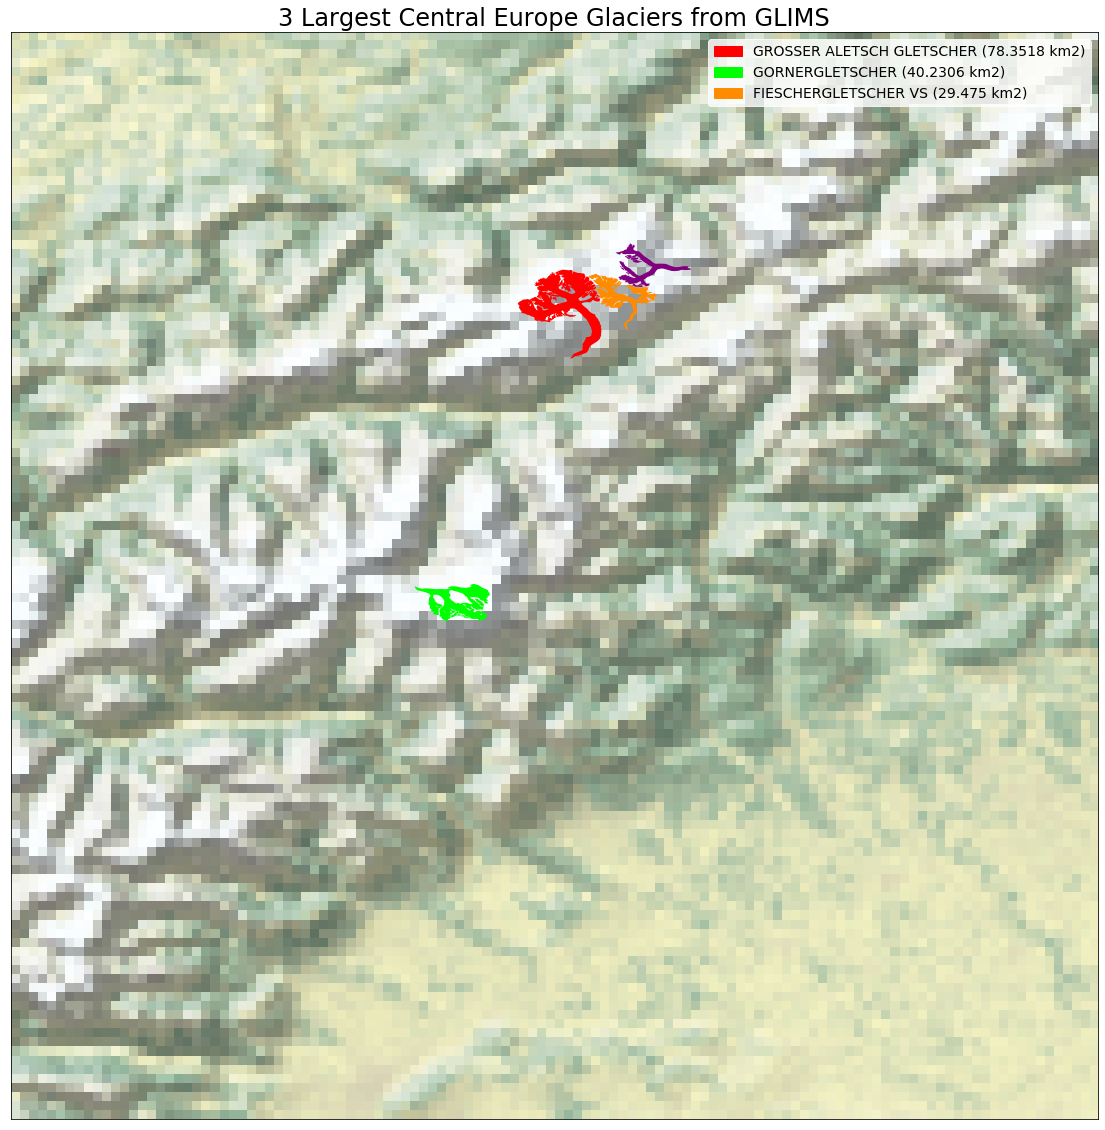

In [13]:
# Plot 3 largest glaciers on natural earth from GLIMS
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [glims_glaciers_df['glac_name'][0] + ' (' + str(glims_glaciers_df['db_area'][0]) + ' km2)',
                 glims_glaciers_df['glac_name'][1] + ' (' + str(glims_glaciers_df['db_area'][1]) + ' km2)',
                 glims_glaciers_df['glac_name'][2] + ' (' + str(glims_glaciers_df['db_area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
minx = 7
miny = 45
maxx = 9
maxy = 47
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
glims_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
glims_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
glims_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
glims_glaciers_df.iloc[3:4].plot(ax=ax, color='purple')
ax.set_title('3 Largest ' + region_name + ' Glaciers from GLIMS', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

## Plot RGI Glaciers

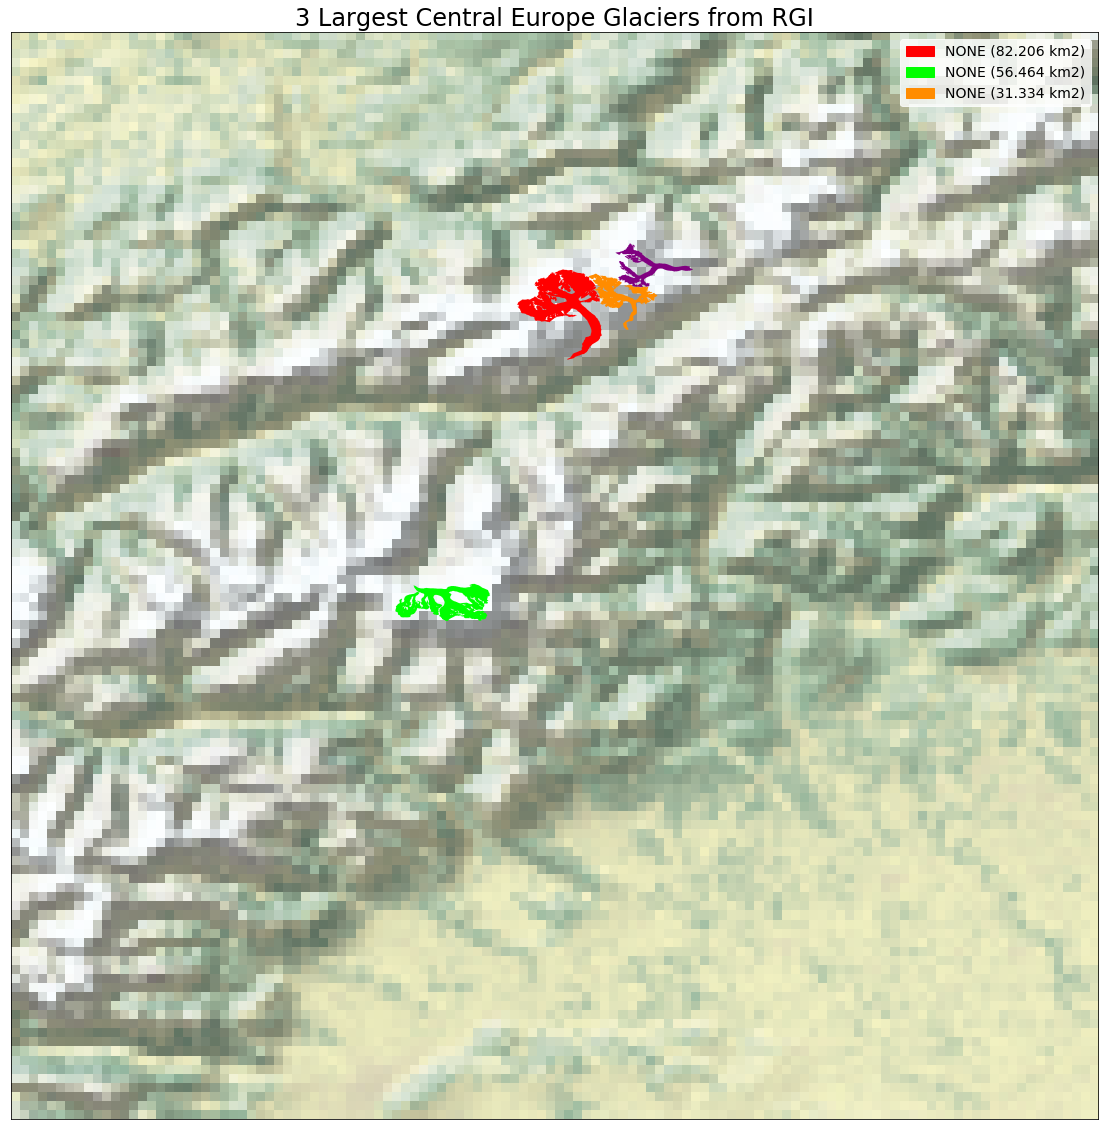

In [14]:
# Plot 3 largest glaciers on natural earth from RGI
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [rgi_glaciers_df['Name'][0] + ' (' + str(rgi_glaciers_df['Area'][0]) + ' km2)',
                 rgi_glaciers_df['Name'][1] + ' (' + str(rgi_glaciers_df['Area'][1]) + ' km2)',
                 rgi_glaciers_df['Name'][2] + ' (' + str(rgi_glaciers_df['Area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
minx = 7
miny = 45
maxx = 9
maxy = 47
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from rgi dataframe
rgi_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
rgi_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
rgi_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
rgi_glaciers_df.iloc[4:5].plot(ax=ax, color='purple')
ax.set_title('3 Largest ' + region_name + ' Glaciers from RGI', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

## Compare Glaciers from GLIMS and RGI
Do they match? If yes, continue, if no, stop notebook and investigate

In [15]:
if (glims_glaciers_df['glac_name'][0] == rgi_glaciers_df['Name'][0] and 
    glims_glaciers_df['glac_name'][1] == rgi_glaciers_df['Name'][1] and 
    glims_glaciers_df['glac_name'][2] == rgi_glaciers_df['Name'][2]):
    print("They match!")
else:
    if handled != 1:
        # If this hasn't been handled, stop execution
        class StopExecution(Exception):
            def _render_traceback_(self):
                pass

        print("They do NOT Match! Stopping notebook.")
        raise StopExecution
    else:
        # If this has been handled, continue execution
        print("They do not match but this has been handled in the code below this section, so continue.")

They do not match but this has been handled in the code below this section, so continue.


## Create final shapefiles
This section creates and formats the final dataframe, plots it to make sure it looks ok, and saves it to a shapefile.

* The 1st one in both GLIMS and RGI is the Grosser Aletsch Glacier. GLIMS has the latest date so will go with that one.
* The 2nd one in both GLIMS and RGI is the Gorner Glacier. GLIMS has the latest date so will go with that one.
* The 3rd one in both GLIMS and RGI is the Fiescher Glacier. GLIMS has the latest date so will go with that one.


### Create final dataframe

In [16]:
# Set up the final dataframe that will be used when saving the final shapefiles
# Drop columns that are not needed for the final data (use GLIMS dataframe for this)
final_data_df = glims_glaciers_df.drop(['area', 'width', 'length', 
                                        'min_elev', 'mean_elev', 'max_elev'], axis=1)

# Add region_name column
final_data_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_data_df['primeclass'] = primeclass

# Rename some columns
final_data_df.rename(columns={'glac_id': 'glims_id', 'db_area': 'area_km2', 
                                       'src_date': 'date'}, inplace=True)

# Drop last 3 rows because they are the fourth and fifthe largest glaciers and we aren't interested in them
final_data_df.drop([3, 4, 5], inplace = True)

# Add RGI ID column
final_data_df['rgi_id'] = (rgi_glaciers_df['RGIId'][0], rgi_glaciers_df['RGIId'][1], rgi_glaciers_df['RGIId'][2])

# Add area_source column that gets filled lower down
final_data_df['area_source'] = '-999'

# Reorder the columns of the dataframe
final_data_df = final_data_df[['region_no', 'reg_name', 'glac_name', 'glims_id', 'rgi_id', 
                               'primeclass', 'area_km2', 'area_source', 'date', 'geometry']]

# Clean up the names of the glaciers
final_data_df.loc[0, 'glac_name'] = "Grosser Aletsch Glacier"
final_data_df.loc[1, 'glac_name'] = "Gorner Glacier"
final_data_df.loc[2, 'glac_name'] = "Fiescher Glacier"

In [17]:
final_data_df

,region_no,reg_name,glac_name,glims_id,rgi_id,primeclass,area_km2,area_source,date,geometry
0,11,Central Europe,Grosser Aletsch Glacier,G008032E46504N,RGI60-11.01450,5,78.3518,-999,2009-09-15T00:00:00,"POLYGON Z ((8.018387000000001 46.562885 0, 8.0..."
1,11,Central Europe,Gorner Glacier,G007800E45965N,RGI60-11.02822,5,40.2306,-999,2009-09-15T00:00:00,"POLYGON Z ((7.877975 45.973549 0, 7.878131 45...."
2,11,Central Europe,Fiescher Glacier,G008144E46504N,RGI60-11.01478,5,29.4750,-999,2009-09-15T00:00:00,"POLYGON Z ((8.078189 46.554764 0, 8.0782120000..."


In [18]:
# Calculate area and update dataframe as neccessary and clean the date format in the date column
# If GLIMS and RGI dates are the same year, then average the two areas.
# If GLIMS date is more recent, then use that average.
# If RGI date is more recent, then use that average. (Note I don't think this ever happens)
# Note only comparing by year because sometimes the month and day are not known. Year matching is close enough.
for x in range(3):
    # Exract and clean GLIMS date so that it is comparable to RGI date
    glims_date = glims_glaciers_df['src_date'][x][0:10].replace('-', '')
    glims_year = glims_date[0:4]
    print('glims date: ' + glims_date)
    #print('glims year: ' + glims_year)
    
    # Extract RGI date
    rgi_date = rgi_glaciers_df['BgnDate'][x]
    rgi_year = rgi_date[0:4]
    print('rgi date: ' + rgi_date)
    #print('rgi year: ' + rgi_year)
    
    if glims_year == rgi_year:
        # Average GLIMS and RGI areas
        area = np.average([glims_glaciers_df['db_area'][x], rgi_glaciers_df['Area'][x]])
        area_source = 'A'
        print('Averaging area: ' + str(area))
    elif glims_year > rgi_year:
        # Use GLIMS area for the area
        area = glims_glaciers_df['db_area'][x]
        area_source = 'G'
        print('Using GLIMS area: ' + str(area))
    elif rgi_year > glims_year:
        # Use RGI area for the area
        area = rgi_glaciers_df['Area'][x]
        area_source = 'R'
        print('Using RGI area: ' + str(area))
    else:
        print("Error. Area could not be calculated.")
    
    print('')
    # Set the area in the final dataframe
    final_data_df.iloc[x, final_data_df.columns.get_loc('area_km2')] = area
    final_data_df.iloc[x, final_data_df.columns.get_loc('area_source')] = area_source
    
    # Clean the date format in the final dataframe
    final_data_df.iloc[x, final_data_df.columns.get_loc('date')] = glims_glaciers_df['src_date'][x][0:10]

glims date: 20090915
rgi date: 20030799
Using GLIMS area: 78.3518

glims date: 20090915
rgi date: 20030799
Using GLIMS area: 40.2306

glims date: 20090915
rgi date: 20030799
Using GLIMS area: 29.475



In [19]:
final_data_df

,region_no,reg_name,glac_name,glims_id,rgi_id,primeclass,area_km2,area_source,date,geometry
0,11,Central Europe,Grosser Aletsch Glacier,G008032E46504N,RGI60-11.01450,5,78.3518,G,2009-09-15,"POLYGON Z ((8.018387000000001 46.562885 0, 8.0..."
1,11,Central Europe,Gorner Glacier,G007800E45965N,RGI60-11.02822,5,40.2306,G,2009-09-15,"POLYGON Z ((7.877975 45.973549 0, 7.878131 45...."
2,11,Central Europe,Fiescher Glacier,G008144E46504N,RGI60-11.01478,5,29.4750,G,2009-09-15,"POLYGON Z ((8.078189 46.554764 0, 8.0782120000..."


### Plot final dataframe to check accuracy

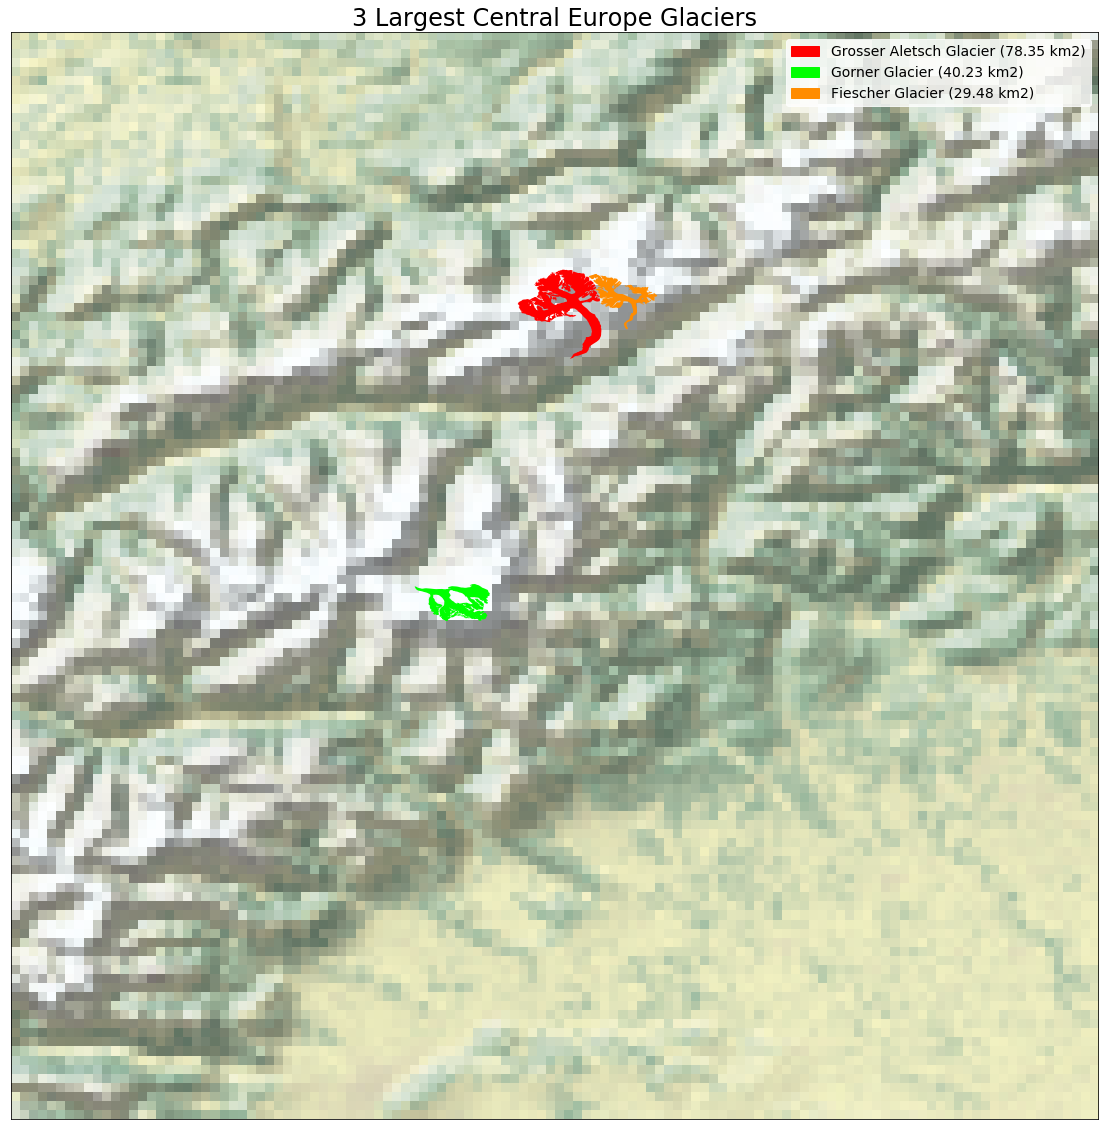

In [20]:
# Check that the geodataframe wasn't corrupted from these changes by plotting the data
# Plot 3 largest glaciers on natural earth from GLIMS
# Set up legend. Note that the sizes come from an average of GLIMS and RGI. 
# See wgms-glacier-project/data/comparison/compare-glims-rgi.xlsx
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [final_data_df['glac_name'][0] + ' (' + str(round(final_data_df['area_km2'][0], 2)) + ' km2)',
                 final_data_df['glac_name'][1] + ' (' + str(round(final_data_df['area_km2'][1], 2)) + ' km2)',
                 final_data_df['glac_name'][2] + ' (' + str(round(final_data_df['area_km2'][2], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
minx = 7
miny = 45
maxx = 9
maxy = 47
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
final_data_df.iloc[0:1].plot(ax=ax, color='red')
final_data_df.iloc[1:2].plot(ax=ax, color='lime')
final_data_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

### Create shapefile from the final dataframe

In [21]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.zip"
if os.path.exists(zipfile_fn) == False:
    # Create the shapefile
    final_data_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.shp"
    final_data_df.to_file(driver='ESRI Shapefile', filename=final_data_fn)
    
    # Zip up the shapefile
    zipfile_fn = ws.zipshp(final_data_fn, Delete=True)
    print("Creating zipfile: " + zipfile_fn)
else:
    print(zipfile_fn + " already extists")

Creating zipfile: data/final-dataset\region-11-largest-glaciers.zip
